# Foggy Cityscapes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow==2.12.1

In [ ]:
from os import listdir
from numpy import asarray
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed

In [ ]:
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)

In [ ]:
path = '/content/drive/MyDrive/FoggyCityscape/'

In [ ]:
dataA = load_images(path + 'Clear/')
#dataAB = load_images(path + 'testA/')
#dataA = vstack((dataA1, dataAB))
print('Loaded dataA: ', dataA.shape)
# load dataset B
dataB = load_images(path + 'Foggy/')
#dataB2 = load_images(path + 'testB/')
#dataB = vstack((dataB1, dataB2))
print('Loaded dataB: ', dataB.shape)
# save as compressed numpy array
filename = 'foggy_256.npz'
savez_compressed(filename, dataA, dataB)
print('Saved dataset: ', filename)

Loaded dataA:  (438, 256, 256, 3)
Loaded dataB:  (438, 256, 256, 3)
Saved dataset:  foggy_256.npz


Loaded:  (438, 256, 256, 3) (438, 256, 256, 3)


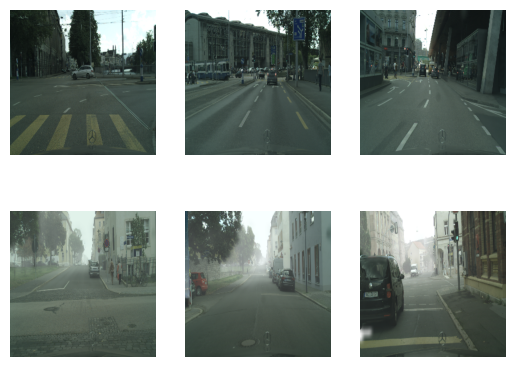

In [ ]:
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('foggy_256.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-_gyjtc35
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-_gyjtc35
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done


In [ ]:
from random import random
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

In [ ]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

# generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

In [ ]:
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [ ]:
# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save('/content/drive/MyDrive/FoggyCityscape/'+filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save('/content/drive/MyDrive/FoggyCityscape/'+filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

In [ ]:
# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

In [ ]:
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	# define properties of the training run
	n_epochs, n_batch, = 100, 1
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 2) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 2) == 0:
			# save the models
			save_models(i, g_model_AtoB, g_model_BtoA)

In [ ]:
from keras.models import load_model
# load image data
cust = {'InstanceNormalization': InstanceNormalization} #Load existing model
dataset = load_real_samples('foggy_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
#g_model_AtoB = define_generator(image_shape)
g_model_AtoB = load_model('/content/drive/MyDrive/FoggyCityscape/FoggyCityscape Models/g_model_AtoB_007008.h5', cust) ##Remove for using previous model
# generator: B -> A
#g_model_BtoA = define_generator(image_shape)
g_model_BtoA = load_model('/content/drive/MyDrive/FoggyCityscape/FoggyCityscape Models/g_model_BtoA_007008.h5', cust) ##Remove for using previous model
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

Loaded (438, 256, 256, 3) (438, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>1, dA[1.170,10.059] dB[1.568,11.748] g[4.663,4.119]
>2, dA[4.427,2.345] dB[7.443,1.017] g[13.554,17.624]
>3, dA[3.742,1.493] dB[1.222,1.367] g[4.049,9.268]
>4, dA[3.003,0.863] dB[0.831,0.602] g[3.211,6.212]
>5, dA[0.976,0.532] dB[0.796,0.608] g[3.517,3.922]
>6, dA[0.875,0.573] dB[0.549,0.389] g[2.844,3.628]
>7, dA[0.669,0.609] dB[0.466,0.765] g[2.643,3.152]
>8, dA[0.838,0.371] dB[0.597,0.568] g[2.885,2.847]
>9, dA[0.580,0.557] dB[0.510,0.391] g[2.689,3.050]
>10, dA[0.601,0.535] dB[0.414,0.399] g[2.634,3.147]
>11, dA[0.590,0.377] dB[0.323,0.383] g[2.430,2.937]
>12, dA[0.460,0.422] dB[0.373,0.414] g[2.545,3.613]
>13, dA[1.305,0.806] dB[0.399,0.256] g[2.488,2.797]
>14, dA[1.169,0.671] dB[0.379,0.596] g[2.445,3.937]
>15, dA[0.729,0.587] dB[0.234,0.571] g[3.849,4.505]
>16, dA[0.482,0.484] dB[0.376,0.372] g[2.068,2.410]
>17, dA[0.443,0.477] dB[0.585,0.240] g[3.826,3.687]
>18, dA[0.439,0.603] dB[0.364,0.290] g[2.302,2.685]
>19, dA[0.453,0.325] dB[0.328,0.263] g[2.439,2.430]
>20, dA[0.306,0.3

## Evaluate Model

In [ ]:
from skimage.metrics import structural_similarity as ssim

def find_ssim(img1,img2):
  gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
  return ssim(gray1,gray2,data_range=gray2.max() - gray2.min())

In [ ]:
import math
import numpy as np
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [ ]:
from numpy import load
from numpy import expand_dims
from keras.models import load_model
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from matplotlib import pyplot
import cv2

# load an image to the preferred size
def load_image(filename, size=(256,256)):
	# load and resize the image
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# transform in a sample
	pixels = expand_dims(pixels, 0)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	return pixels

1/1 [==============================] - 5s 5s/step


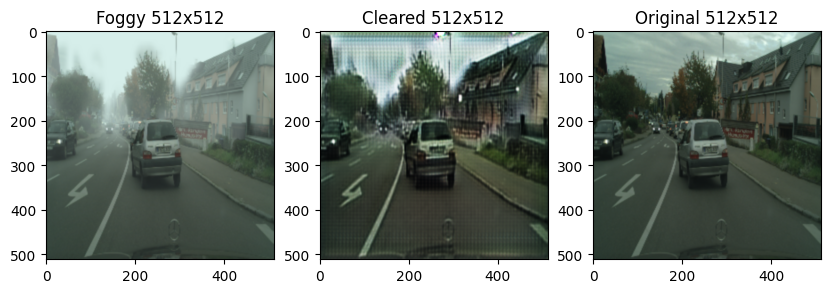

Image layer range: 0.0092408955 1.0
Image layer_org range: 0.044852912 1.0
PSNR: 19.76452598898357
SSIM: 0.7509954733243112


In [ ]:
image_src = load_image('/content/drive/MyDrive/FoggyCityscape/Validation/Foggy/lindau_000000_000019_leftImg8bit_foggy_beta_0.01.png')
original = load_image('/content/drive/MyDrive/FoggyCityscape/Validation/Clear/lindau_000000_000019_leftImg8bit.png')
# load the model
cust = {'InstanceNormalization': InstanceNormalization}
model_BtoA = load_model('/content/drive/MyDrive/FoggyCityscape/FoggyCityscape Models/g_model_BtoA_007884.h5', cust)


# translate image
image_tar = model_BtoA.predict(image_src)
image_tar = (image_tar + 1) / 2.0


layer = image_tar[0].copy()
layer_src = image_src[0].copy()
layer_org = original[0].copy()
for i in range(1):
	rows, cols, _channels = map(int, layer.shape)
	#pyplot.subplot(2, 2, i+1)
	layer = cv2.pyrUp(layer,dstsize=(2 * cols, 2 * rows))
	layer_src = cv2.pyrUp(layer_src,dstsize=(2 * cols, 2 * rows))
	layer_org = cv2.pyrUp(layer_org,dstsize=(2 * cols, 2 * rows))

fig = pyplot.figure(figsize=(10, 8))
fig.add_subplot(2, 3, 1)
layer_src_display = (layer_src+1) / 2
pyplot.imshow(layer_src_display)
pyplot.title("Foggy 512x512")

fig.add_subplot(2, 3, 2)
pyplot.imshow(layer)
pyplot.title("Cleared 512x512")

layer_org = (layer_org+1)/2
fig.add_subplot(2, 3, 3)
pyplot.imshow(layer_org)
pyplot.title("Original 512x512")
pyplot.show()

print("Image layer range:", np.min(layer), np.max(layer))
print("Image layer_org range:", np.min(layer_org), np.max(layer))

print("PSNR:",psnr(layer_org, layer))
print("SSIM:",find_ssim(layer_org,layer))

1/1 [==============================] - 4s 4s/step


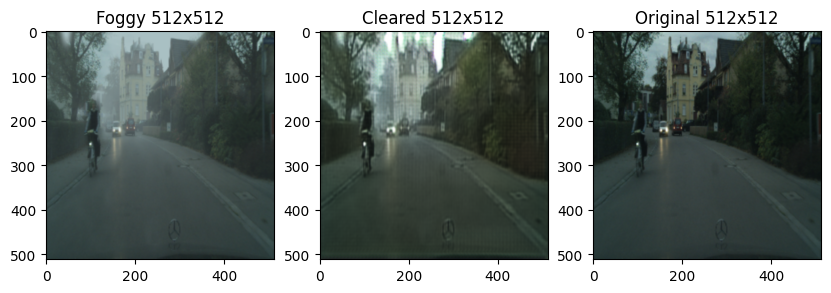

PSNR: 18.564654738992516
SSIM: 0.8527600113243159


In [ ]:
image_src = load_image('/content/drive/MyDrive/FoggyCityscape/Validation/Foggy/lindau_000012_000019_leftImg8bit_foggy_beta_0.01.png')
original = load_image('/content/drive/MyDrive/FoggyCityscape/Validation/Clear/lindau_000012_000019_leftImg8bit.png')
# load the model
cust = {'InstanceNormalization': InstanceNormalization}
model_BtoA = load_model('/content/drive/MyDrive/FoggyCityscape/FoggyCityscape Models/g_model_BtoA_007884.h5', cust)
# translate image
image_tar = model_BtoA.predict(image_src)
image_tar = (image_tar + 1) / 2.0

layer = image_tar[0].copy()
layer_src = image_src[0].copy()
layer_org = original[0].copy()
for i in range(1):
	rows, cols, _channels = map(int, layer.shape)
	#pyplot.subplot(2, 2, i+1)
	layer = cv2.pyrUp(layer,dstsize=(2 * cols, 2 * rows))
	layer_src = cv2.pyrUp(layer_src,dstsize=(2 * cols, 2 * rows))
	layer_org = cv2.pyrUp(layer_org,dstsize=(2 * cols, 2 * rows))

fig = pyplot.figure(figsize=(10, 8))
fig.add_subplot(2, 3, 1)
layer_src_display = (layer_src+1) / 2
pyplot.imshow(layer_src_display)
pyplot.title("Foggy 512x512")

fig.add_subplot(2, 3, 2)
pyplot.imshow(layer)
pyplot.title("Cleared 512x512")

layer_org = (layer_org+1)/2
fig.add_subplot(2, 3, 3)
pyplot.imshow(layer_org)
pyplot.title("Original 512x512")
pyplot.show()

print("PSNR:",psnr(layer_org,layer))
print("SSIM:",find_ssim(layer_org,layer))

1/1 [==============================] - 4s 4s/step


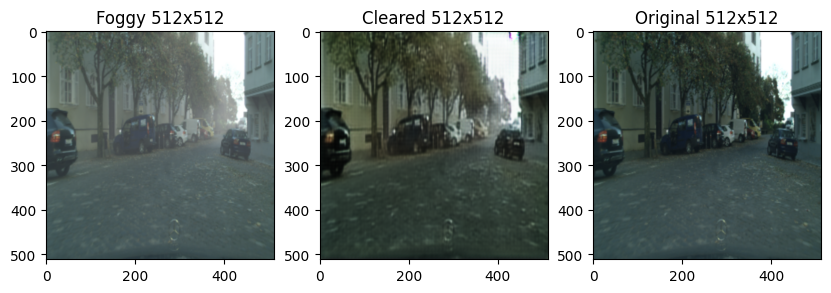

PSNR: 19.900236704878292
SSIM: 0.8742458053502699


In [ ]:
image_src = load_image('/content/drive/MyDrive/FoggyCityscape/Validation/Foggy/lindau_000041_000019_leftImg8bit_foggy_beta_0.01.png')
original = load_image('/content/drive/MyDrive/FoggyCityscape/Validation/Clear/lindau_000041_000019_leftImg8bit.png')
# load the model
cust = {'InstanceNormalization': InstanceNormalization}
model_BtoA = load_model('/content/drive/MyDrive/FoggyCityscape/FoggyCityscape Models/g_model_BtoA_007884.h5', cust)
# translate image
image_tar = model_BtoA.predict(image_src)
image_tar = (image_tar + 1) / 2.0

layer = image_tar[0].copy()
layer_src = image_src[0].copy()
layer_org = original[0].copy()
for i in range(1):
	rows, cols, _channels = map(int, layer.shape)
	#pyplot.subplot(2, 2, i+1)
	layer = cv2.pyrUp(layer,dstsize=(2 * cols, 2 * rows))
	layer_src = cv2.pyrUp(layer_src,dstsize=(2 * cols, 2 * rows))
	layer_org = cv2.pyrUp(layer_org,dstsize=(2 * cols, 2 * rows))

fig = pyplot.figure(figsize=(10, 8))
fig.add_subplot(2, 3, 1)
layer_src_display = (layer_src+1) / 2
pyplot.imshow(layer_src_display)
pyplot.title("Foggy 512x512")

fig.add_subplot(2, 3, 2)
pyplot.imshow(layer)
pyplot.title("Cleared 512x512")

layer_org = (layer_org+1)/2
fig.add_subplot(2, 3, 3)
pyplot.imshow(layer_org)
pyplot.title("Original 512x512")
pyplot.show()

print("PSNR:",psnr(layer_org,layer))
print("SSIM:",find_ssim(layer_org,layer))

1/1 [==============================] - 3s 3s/step


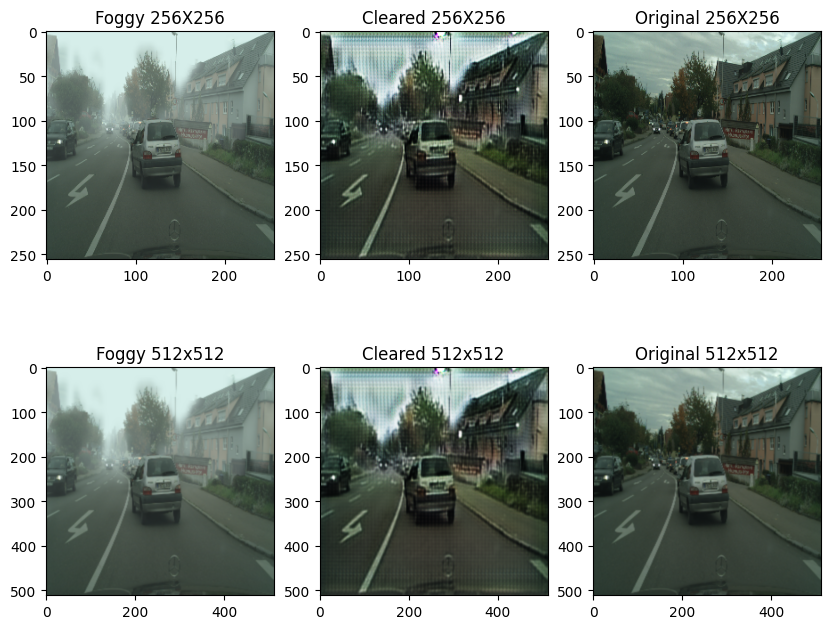

PSNR: 19.76452598898357
SSIM: 0.7509954733243112


In [ ]:
image_src = load_image('/content/drive/MyDrive/FoggyCityscape/Validation/Foggy/lindau_000000_000019_leftImg8bit_foggy_beta_0.01.png')
original = load_image('/content/drive/MyDrive/FoggyCityscape/Validation/Clear/lindau_000000_000019_leftImg8bit.png')
# load the model
cust = {'InstanceNormalization': InstanceNormalization}
model_BtoA = load_model('/content/drive/MyDrive/FoggyCityscape/FoggyCityscape Models/g_model_BtoA_007884.h5', cust)
# translate image
image_tar = model_BtoA.predict(image_src)

# scale from [-1,1] to [0,1]
image_tar = (image_tar + 1) / 2.0
# plot the translated image
layer = image_tar[0].copy()
layer_src = image_src[0].copy()
layer_org = original[0].copy()
for i in range(1):
	rows, cols, _channels = map(int, layer.shape)
	#pyplot.subplot(2, 2, i+1)
	layer = cv2.pyrUp(layer,dstsize=(2 * cols, 2 * rows))
	layer_src = cv2.pyrUp(layer_src,dstsize=(2 * cols, 2 * rows))
	layer_org = cv2.pyrUp(layer_org,dstsize=(2 * cols, 2 * rows))

fig = pyplot.figure(figsize=(10, 8))
fig.add_subplot(2, 3, 1)
image_display = (image_src[0] + 1) / 2
pyplot.imshow(image_display)
pyplot.title("Foggy 256X256")

fig.add_subplot(2, 3, 2)
pyplot.imshow(image_tar[0])
pyplot.title("Cleared 256X256")


original = (original + 1) /2
fig.add_subplot(2, 3, 3)
pyplot.imshow(original[0])
pyplot.title("Original 256X256")

fig.add_subplot(2, 3, 4)
layer_src_display = (layer_src+1) / 2
pyplot.imshow(layer_src_display)
pyplot.title("Foggy 512x512")

fig.add_subplot(2, 3, 5)
pyplot.imshow(layer)
pyplot.title("Cleared 512x512")

layer_org = (layer_org+1)/2
fig.add_subplot(2, 3, 6)
pyplot.imshow(layer_org)
pyplot.title("Original 512x512")

pyplot.show()

print("PSNR:",psnr(layer_org,layer))
print("SSIM:",find_ssim(layer_org,layer))

1/1 [==============================] - 4s 4s/step


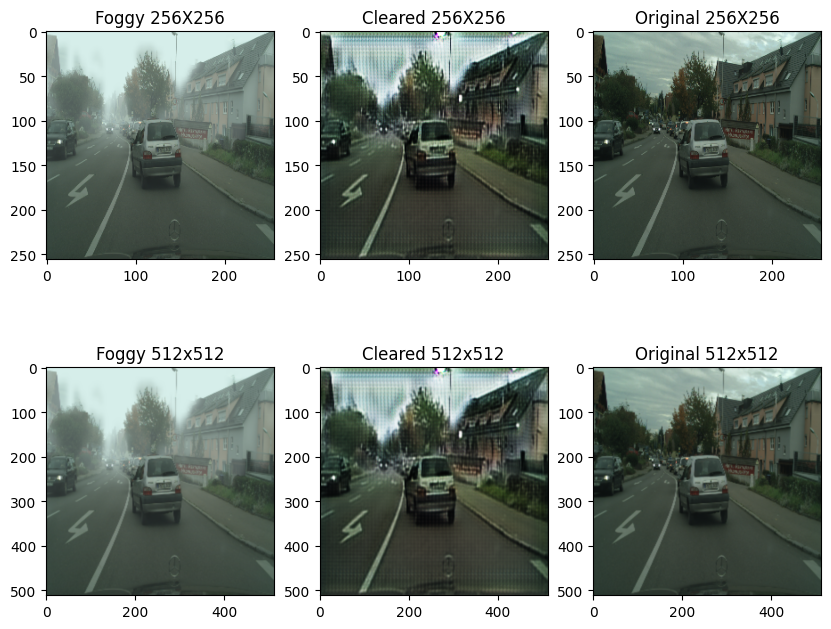

PSNR: 19.646451150380877
SSIM: 0.7309928166199647


In [ ]:
def load_image(filename, size=(256,256)):
	# load and resize the image
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# transform in a sample
	pixels = expand_dims(pixels, 0)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	return pixels
image_src = load_image('/content/drive/MyDrive/FoggyCityscape/Validation/Foggy/lindau_000000_000019_leftImg8bit_foggy_beta_0.01.png')
original = load_image('/content/drive/MyDrive/FoggyCityscape/Validation/Clear/lindau_000000_000019_leftImg8bit.png')
# load the model
cust = {'InstanceNormalization': InstanceNormalization}
model_BtoA = load_model('/content/drive/MyDrive/FoggyCityscape/FoggyCityscape Models/g_model_BtoA_007884.h5', cust)
# translate image
image_tar = model_BtoA.predict(image_src)

# scale from [-1,1] to [0,1]
image_tar = (image_tar + 1) / 2.0
# plot the translated image
layer = image_tar[0].copy()
layer_src = image_src[0].copy()
layer_org = original[0].copy()
rows, cols, _channels = map(int, layer.shape)
#pyplot.subplot(2, 2, i+1)
layer = cv2.resize(layer,(2 * cols, 2 * rows))
layer_src = cv2.resize(layer_src,(2 * cols, 2 * rows))
layer_org = cv2.resize(layer_org, (2 * cols, 2 * rows))

fig = pyplot.figure(figsize=(10, 8))
fig.add_subplot(2, 3, 1)
image_display = (image_src[0] + 1) / 2
pyplot.imshow(image_display)
pyplot.title("Foggy 256X256")

fig.add_subplot(2, 3, 2)
pyplot.imshow(image_tar[0])
pyplot.title("Cleared 256X256")


original = (original + 1) /2
fig.add_subplot(2, 3, 3)
pyplot.imshow(original[0])
pyplot.title("Original 256X256")

fig.add_subplot(2, 3, 4)
layer_src_display = (layer_src+1) / 2
pyplot.imshow(layer_src_display)
pyplot.title("Foggy 512x512")

fig.add_subplot(2, 3, 5)
pyplot.imshow(layer)
pyplot.title("Cleared 512x512")

layer_org = (layer_org+1)/2
fig.add_subplot(2, 3, 6)
pyplot.imshow(layer_org)
pyplot.title("Original 512x512")

pyplot.show()

print("PSNR:",psnr(layer_org,layer))
print("SSIM:",find_ssim(layer_org,layer))

Without Resizing image:

In [ ]:
import cv2
import glob
hazy_path = '/content/drive/MyDrive/FoggyCityscape/Validation/Foggy/*.png'
gt_path = '/content/drive/MyDrive/FoggyCityscape/Validation/Clear/'

ttl_psnr = 0
ttl_ssim = 0
counter = 0
cust = {'InstanceNormalization': InstanceNormalization}
model_BtoA = load_model('/content/drive/MyDrive/FoggyCityscape/FoggyCityscape Models/g_model_BtoA_007884.h5', cust)

for file in glob.glob(hazy_path):
  counter+=1
  #a = load_image(gt_path+file[33:37]+'.png')
  a = load_image(gt_path+file[55:-20]+'.png')
  b = load_image(file)

  # translate image
  image_tar = model_BtoA.predict(b)
  # scale from [-1,1] to [0,1]
  image_tar = (image_tar + 1) / 2.0
  a = (a + 1 ) / 2.0
  ttl_psnr+=psnr(a[0],image_tar[0])
  ttl_ssim+=(find_ssim(a[0],image_tar[0])) #For foggyCityScapes
print("PSNR:",ttl_psnr/counter)
print("SSIM:",ttl_ssim/counter)

1/1 [==============================] - 3s 3s/step
PSNR: 20.049974232037304
SSIM: 0.7878351340526172


Using Pyramind Upscaling:

In [ ]:
import cv2
import glob
hazy_path = '/content/drive/MyDrive/FoggyCityscape/Validation/Foggy/*.png'
gt_path = '/content/drive/MyDrive/FoggyCityscape/Validation/Clear/'

ttl_psnr = 0
ttl_ssim = 0
counter = 0

cust = {'InstanceNormalization': InstanceNormalization}
model_BtoA = load_model('/content/drive/MyDrive/FoggyCityscape/FoggyCityscape Models/g_model_BtoA_007884.h5', cust)

for file in glob.glob(hazy_path):
  counter+=1
  #a = load_image(gt_path+file[33:37]+'.png')
  a = load_image(gt_path+file[55:-20]+'.png')
  b = load_image(file)

  # translate image
  image_tar = model_BtoA.predict(b)
  # scale from [-1,1] to [0,1]
  image_tar = (image_tar + 1) / 2.0
  a = (a + 1 ) / 2.0
  layer = image_tar[0].copy()
  layer_src = a[0].copy()
  for i in range(1):
    rows, cols, _channels = map(int, layer.shape)
    #pyplot.subplot(2, 2, i+1)
    layer = cv2.pyrUp(layer,dstsize=(2 * cols, 2 * rows))
    layer_src = cv2.pyrUp(layer_src,dstsize=(2 * cols, 2 * rows))
  ttl_psnr+=psnr(layer_src,layer)
  ttl_ssim+=(find_ssim(layer_src,layer)) #For foggyCityScapes
print("PSNR:",ttl_psnr/counter)
print("SSIM:",ttl_ssim/counter)

1/1 [==============================] - 3s 3s/step
PSNR: 20.535950110865233
SSIM: 0.8461339908148173


Results using cv2's default linear interpolation

In [ ]:
import glob
hazy_path = '/content/drive/MyDrive/FoggyCityscape/Validation/Foggy/*.png'
gt_path = '/content/drive/MyDrive/FoggyCityscape/Validation/Clear/'

ttl_psnr = 0
ttl_ssim = 0
counter = 0

cust = {'InstanceNormalization': InstanceNormalization}
model_BtoA = load_model('/content/drive/MyDrive/FoggyCityscape/FoggyCityscape Models/g_model_BtoA_007884.h5', cust)

for file in glob.glob(hazy_path):
  counter+=1
  #a = load_image(gt_path+file[33:37]+'.png')
  a = load_image(gt_path+file[55:-20]+'.png')
  b = load_image(file)

  # translate image
  image_tar = model_BtoA.predict(b)
  # scale from [-1,1] to [0,1]
  image_tar = (image_tar + 1) / 2.0
  a = (a + 1 ) / 2.0
  layer = image_tar[0].copy()
  layer_src = a[0].copy()
  rows, cols, _channels = map(int, layer.shape)
  #pyplot.subplot(2, 2, i+1)
  layer = cv2.resize(layer,(2 * cols, 2 * rows))
  layer_src = cv2.resize(layer_src,(2 * cols, 2 * rows))
  layer_org = cv2.resize(layer_org, (2 * cols, 2 * rows))
  ttl_psnr+=psnr(layer_src,layer)
  ttl_ssim+=(find_ssim(layer_src,layer)) #For foggyCityScapes
print("PSNR:",ttl_psnr/counter)
print("SSIM:",ttl_ssim/counter)

1/1 [==============================] - 3s 3s/step
PSNR: 20.44326788869308
SSIM: 0.8313961141826024


In [ ]:
print(counter)

59
